In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
from IPython.display import display
sns.reset_orig()
sns.set_palette('crest')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import get_models
from catalogue import collect_catalogue_from_ATNF

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_20 = 'outdir_20_percent_threshold'
outdir_50 = 'outdir_50_percent_error'
outdir_aic = 'outdir_aic'

# Run the following commands beforehand to generate the output files
# (best to run them in a terminal to track the progress and outputs)
# ! cd .. && python fit.py --outdir {outdir_10} --err_thresh 0.1
# ! cd .. && python fit.py --outdir {outdir_20} --err_thresh 0.2
# ! cd .. && python fit.py --outdir {outdir_50} --no_err --outliers_all 0.5
# ! cd .. && python fit.py --outdir {outdir_aic} --aic
# ! cd .. && python processing.py {outdir_10}
# ! cd .. && python processing.py {outdir_10} --var param_estimates
# ! cd .. && python processing.py {outdir_20}
# ! cd .. && python processing.py {outdir_20} --var param_estimates
# ! cd .. && python processing.py {outdir_50}
# ! cd .. && python processing.py {outdir_aic} --var aic

In [2]:
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
print(f'Number of pulsars in the catalogue: {len(catalogue)}')
for n in range(4, 7):
    print(f'Number of pulsars with {n} or more flux density measurements: {len(catalogue.at_least_n_points(n))}')
    
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
    return results
results_10 = load_results(outdir_10, 'log_evidence')
results_20 = load_results(outdir_20, 'log_evidence')
results_50 = load_results(outdir_50, 'log_evidence')
results_aic = load_results(outdir_aic, 'aic')

print(f'Number of pulsars reaching requirements for fitting: {len(results_10)}')
print('(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)')

Number of pulsars in the catalogue: 3345
Number of pulsars with 4 or more flux density measurements: 1580
Number of pulsars with 5 or more flux density measurements: 1516
Number of pulsars with 6 or more flux density measurements: 1437
Number of pulsars reaching requirements for fitting: 872
(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)


Best-fitting classification by the four methods:


,Model,10% threshold,20% threshold,50% error,AIC
0,log-parabolic spectrum,448,508,586,196
1,broken power law,281,213,162,268
2,low-frequency turn-over power law,84,81,65,65
3,simple power law,38,55,52,226
4,high-frequency cut-off power law,21,15,7,109


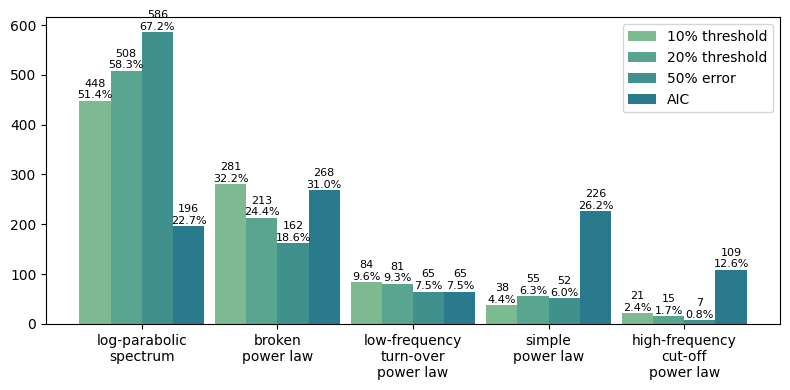

In [3]:
print('Best-fitting classification by the four methods:')

def model_name_cap(model_name: str | np.ndarray):
    if isinstance(model_name, np.ndarray):
        return np.array([model_name_cap(m) for m in model_name])
    return model_name.replace('_', ' ').replace('g ', 'g-').replace(' f', '-f').replace(' o', '-o')
def model_name_br(model_name: str | np.ndarray):
    if isinstance(model_name, np.ndarray):
        return np.array([model_name_br(m) for m in model_name])
    return model_name_cap(model_name).replace(' ', '\n').replace('r\nl', 'r l')

x_10 = results_10['best_fitting'].value_counts().index.to_numpy()
y_10 = results_10['best_fitting'].value_counts().to_numpy()
x_20 = results_20['best_fitting'].value_counts().index.to_numpy()
y_20 = results_20['best_fitting'].value_counts().to_numpy()
x_50 = results_50['best_fitting'].value_counts().index.to_numpy()
y_50 = results_50['best_fitting'].value_counts().to_numpy()
x_aic = results_aic['best_fitting'].value_counts().index.to_numpy()
y_aic = results_aic['best_fitting'].value_counts().to_numpy()

# sort by x_10
x_20, y_20 = zip(*sorted(zip(x_20, y_20), key=lambda x: x_10.tolist().index(x[0])))
x_50, y_50 = zip(*sorted(zip(x_50, y_50), key=lambda x: x_10.tolist().index(x[0])))
x_aic, y_aic = zip(*sorted(zip(x_aic, y_aic), key=lambda x: x_10.tolist().index(x[0])))

display(pd.DataFrame({
    'Model': model_name_cap(x_10),
    '10% threshold': y_10,
    '20% threshold': y_20,
    '50% error': y_50,
    'AIC': y_aic
}))

fig, ax = plt.subplots(figsize=(8, 4))

bar_width = 0.23
bar_positions = np.arange(len(x_10))

ax.bar(bar_positions - bar_width * 1.5, y_10, bar_width, label='10% threshold')
ax.bar(bar_positions - bar_width * 0.5, y_20, bar_width, label='20% threshold')
ax.bar(bar_positions + bar_width * 0.5, y_50, bar_width, label='50% error')
ax.bar(bar_positions + bar_width * 1.5, y_aic, bar_width, label='AIC')
labels_10 = [f'{v}\n{v/np.sum(y_10)*100:.1f}%' for v in y_10]
labels_20 = [f'{v}\n{v/np.sum(y_20)*100:.1f}%' for v in y_20]
labels_50 = [f'{v}\n{v/np.sum(y_50)*100:.1f}%' for v in y_50]
labels_aic = [f'{v}\n{v/np.sum(y_aic)*100:.1f}%' for v in y_aic]
for i, (label_10, label_20, label_50, label_aic) in enumerate(zip(labels_10, labels_20, labels_50, labels_aic)):
    ax.text(i - bar_width * 1.5, y_10[i] + 1, label_10, ha='center', va='bottom', fontsize=8)
    ax.text(i - bar_width * 0.5, y_20[i] + 1, label_20, ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width * 0.5, y_50[i] + 1, label_50, ha='center', va='bottom', fontsize=8)
    ax.text(i + bar_width * 1.5, y_aic[i] + 1, label_aic, ha='center', va='bottom', fontsize=8)

ax.set_xticks(bar_positions)
ax.set_xticklabels(model_name_br(x_10))
ax.legend()
plt.tight_layout()
plt.show()

In [4]:
print('Bayes factors (versus simple power law):')

results_10_bf = results_10.drop(columns='best_fitting').sub(results_10['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_20_bf = results_20.drop(columns='best_fitting').sub(results_20['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_50_bf = results_50.drop(columns='best_fitting').sub(results_50['simple_power_law'], axis=0).drop(columns='simple_power_law')

results_bf_gt5 = pd.DataFrame({
    '10% threshold': (results_10_bf > 5).sum(),
    '20% threshold': (results_20_bf > 5).sum(),
    '50% error': (results_50_bf > 5).sum()
})
# sort by 10% threshold
results_bf_gt5 = results_bf_gt5.loc[results_bf_gt5['10% threshold'].sort_values(ascending=False).index]

results_bf_gt5.loc['(Any BF > 5)'] = [
    (results_10_bf > 5).any(axis=1).sum(),
    (results_20_bf > 5).any(axis=1).sum(),
    (results_50_bf > 5).any(axis=1).sum()
]
results_bf_gt5.loc['(All BF < -5)'] = [
    (results_10_bf < -5).all(axis=1).sum(),
    (results_20_bf < -5).all(axis=1).sum(),
    (results_50_bf < -5).all(axis=1).sum()
]

# change the values to {} / {} = {}% format
results_bf_gt5 = results_bf_gt5.applymap(lambda x: f'{x:d} / {len(results_10)} = {x/len(results_10)*100:.1f}%')

results_bf_gt5

Bayes factors (versus simple power law):


,10% threshold,20% threshold,50% error
log_parabolic_spectrum,366 / 872 = 42.0%,294 / 872 = 33.7%,184 / 872 = 21.1%
broken_power_law,343 / 872 = 39.3%,254 / 872 = 29.1%,149 / 872 = 17.1%
low_frequency_turn_over_power_law,292 / 872 = 33.5%,215 / 872 = 24.7%,153 / 872 = 17.5%
high_frequency_cut_off_power_law,191 / 872 = 21.9%,110 / 872 = 12.6%,64 / 872 = 7.3%
(Any BF > 5),418 / 872 = 47.9%,332 / 872 = 38.1%,199 / 872 = 22.8%
(All BF < -5),0 / 872 = 0.0%,0 / 872 = 0.0%,0 / 872 = 0.0%


Systematic error distribution:


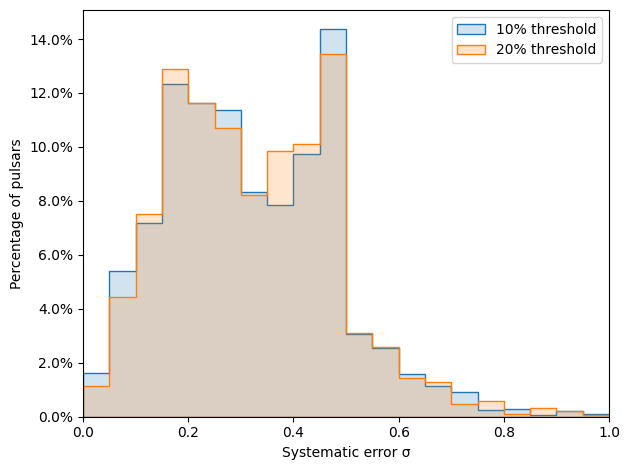

In [5]:
print('Systematic error distribution:')

with open(f'../output/results_param_estimates_from_{outdir_10}.json', 'r', encoding='utf-8-sig') as f:
    param_est_10 = json.load(f)
with open(f'../output/results_param_estimates_from_{outdir_20}.json', 'r', encoding='utf-8-sig') as f:
    param_est_20 = json.load(f)
    
model_dict = get_models('simple_power_law;broken_power_law;log_parabolic_spectrum;high_frequency_cut_off_power_law;low_frequency_turn_over_power_law')

sigma_10, sigma_20 = {}, {}
for model in model_dict:
    sigma_10[model], sigma_20[model] = [], []
    for jname in results_10.index:
        if jname not in catalogue.cat_dict or model not in param_est_10[jname]:
            continue
        sigma_10[model].append(param_est_10[jname][model]['median'][-1])
    for jname in results_20.index:
        if jname not in catalogue.cat_dict or model not in param_est_20[jname]:
            continue
        sigma_20[model].append(param_est_20[jname][model]['median'][-1])  # the last parameter is the error
        
sigma_all_10 = np.concatenate([sigma_10[model] for model in model_dict])
sigma_all_20 = np.concatenate([sigma_20[model] for model in model_dict])

fig, ax = plt.subplots()
sns.histplot(sigma_all_10, binwidth=0.05, binrange=(0, 1), kde=False, label='10% threshold', stat='probability', element='step', color='tab:blue', alpha=0.2, ax=ax)
sns.histplot(sigma_all_20, binwidth=0.05, binrange=(0, 1), kde=False, label='20% threshold', stat='probability', element='step', color='tab:orange', alpha=0.2, ax=ax)
ax.set_xlim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Systematic error σ')
ax.set_ylabel('Percentage of pulsars')
ax.legend()
plt.tight_layout()
plt.savefig('Systematic error distribution.pdf', bbox_inches='tight')
plt.show()

Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:
Without systematic error:


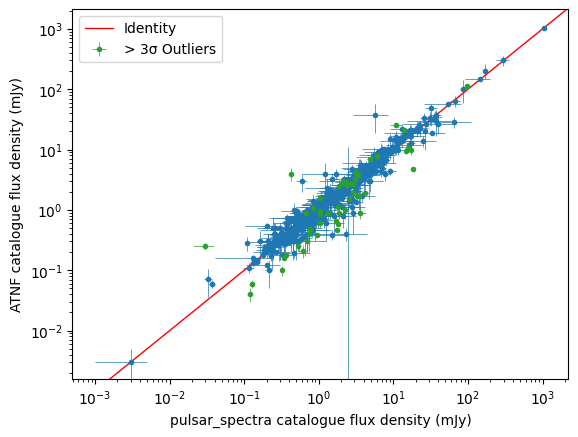

With systematic error:


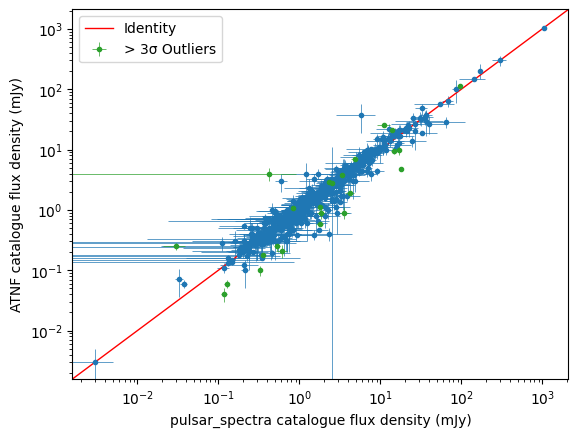

In [6]:
jname_list = list(param_est_10.keys())
atnf_latest_cat = collect_catalogue_from_ATNF(jname_list, atnf_ver='latest')

print('Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:')

central_freq = 1400.
pul_cat_Ys = []
pul_cat_YERRs = []
pul_cat_YERRs_mod = []
atnf_Ys = []
atnf_YERRs = []

for jname in results_10.index:
    if jname not in atnf_latest_cat.cat_dict:
        continue
    if jname not in param_est_10:
        continue
    
    pul_cat_Y_in_range = []
    pul_cat_YERR_in_range = []
    for i, freq in enumerate(catalogue.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            pul_cat_Y_in_range.append(catalogue.cat_dict[jname]['Y'][i])
            pul_cat_YERR_in_range.append(catalogue.cat_dict[jname]['YERR'][i])
            
    if len(pul_cat_Y_in_range) < 1:
        continue
        
    atnf_Y_in_range = []
    atnf_YERR_in_range = []
    for i, freq in enumerate(atnf_latest_cat.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            atnf_Y_in_range.append(atnf_latest_cat.cat_dict[jname]['Y'][i])
            atnf_YERR_in_range.append(atnf_latest_cat.cat_dict[jname]['YERR'][i])
                
    if len(atnf_Y_in_range) < 1:
        continue
        
    if len(pul_cat_Y_in_range) > 1:
        pul_cat_Y_in_range = np.array(pul_cat_Y_in_range)
        pul_cat_YERR_in_range = np.array(pul_cat_YERR_in_range)
        
        # Best model
        best_model = results_10.loc[jname, 'best_fitting']
        sigma = param_est_10[jname][best_model]['median'][-1]
        # add sigma to the errors that are less than 10% of the flux
        pul_cat_10_percent = np.where(pul_cat_YERR_in_range < 0.1 * pul_cat_Y_in_range)
        pul_cat_YERR_mod_in_range = np.copy(pul_cat_YERR_in_range)
        pul_cat_YERR_mod_in_range[pul_cat_10_percent] = np.sqrt(pul_cat_YERR_in_range[pul_cat_10_percent] ** 2 + sigma ** 2)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        pul_cat_Y = np.median(pul_cat_Y_in_range)
        pul_cat_YERR = pul_cat_YERR_in_range[np.argmin(np.abs(pul_cat_Y_in_range - pul_cat_Y))]
        pul_cat_YERR_mod = pul_cat_YERR_mod_in_range[np.argmin(np.abs(pul_cat_Y_in_range - pul_cat_Y))]
        
    else:
        pul_cat_Y = pul_cat_Y_in_range[0]
        pul_cat_YERR = pul_cat_YERR_in_range[0]
        pul_cat_YERR_mod = pul_cat_YERR_in_range[0]
        
    if len(atnf_Y_in_range) > 1:
        atnf_Y_in_range = np.array(atnf_Y_in_range)
        atnf_YERR_in_range = np.array(atnf_YERR_in_range)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        atnf_Y = np.median(atnf_Y_in_range)
        atnf_YERR = atnf_YERR_in_range[np.argmin(np.abs(atnf_Y_in_range - atnf_Y))]
        
    else:
        atnf_Y = atnf_Y_in_range[0]
        atnf_YERR = atnf_YERR_in_range[0]
        
    pul_cat_Ys.append(pul_cat_Y)
    pul_cat_YERRs.append(pul_cat_YERR)
    pul_cat_YERRs_mod.append(pul_cat_YERR_mod)
    atnf_Ys.append(atnf_Y)
    atnf_YERRs.append(atnf_YERR)
        
def draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, title: str):
    # Group the data by outliers (> 3 sigma) and inliers
    pul_cat_Ys = np.array(pul_cat_Ys)
    pul_cat_YERRs = np.array(pul_cat_YERRs)
    atnf_Ys = np.array(atnf_Ys)
    atnf_YERRs = np.array(atnf_YERRs)
    
    outliers = np.abs(pul_cat_Ys - atnf_Ys) > 3 * np.sqrt(pul_cat_YERRs ** 2 + atnf_YERRs ** 2)
    pul_cat_Ys_outliers = pul_cat_Ys[outliers]
    pul_cat_YERRs_outliers = pul_cat_YERRs[outliers]
    atnf_Ys_outliers = atnf_Ys[outliers]
    atnf_YERRs_outliers = atnf_YERRs[outliers]
    
    pul_cat_Ys_inliers = pul_cat_Ys[~outliers]
    pul_cat_YERRs_inliers = pul_cat_YERRs[~outliers]
    atnf_Ys_inliers = atnf_Ys[~outliers]
    atnf_YERRs_inliers = atnf_YERRs[~outliers]
            
    # Draw a scatter plot
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(pul_cat_Ys_inliers, atnf_Ys_inliers, xerr=pul_cat_YERRs_inliers, yerr=atnf_YERRs_inliers, fmt='o', elinewidth=0.5, color='tab:blue', markersize=3)
    plt.errorbar(pul_cat_Ys_outliers, atnf_Ys_outliers, xerr=pul_cat_YERRs_outliers, yerr=atnf_YERRs_outliers, fmt='o', label='> 3σ Outliers', elinewidth=0.5, color='tab:green', markersize=3)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([0, 1e4], [0, 1e4], 'r-', label='Identity', linewidth=1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('pulsar_spectra catalogue flux density (mJy)')
    plt.ylabel('ATNF catalogue flux density (mJy)')
    plt.legend()
    plt.savefig(title + '.pdf', bbox_inches='tight')
    plt.show()

print('Without systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, 'Flux density comparison with ATNF catalogue (without systematic error)')
print('With systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs_mod, atnf_Ys, atnf_YERRs, 'Flux density comparison with ATNF catalogue (with systematic error)')